# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

0.3231253485383533
2.8165633126625327 0.31933659067058423
2.8205641128225647 0.3155427213798149
2.8245649129825967 0.3117438013921611
2.8285657131426287 0.3079398915145818
2.8325665133026607 0.3041310526339062
2.8365673134626928 0.300317345715859
2.8405681136227248 0.29649883180408443
2.844568913782757 0.2926755720191694
2.8485697139427884 0.28884762755766547
2.8525705141028204 0.2850150596911077
2.8565713142628524 0.28117792976503625
2.8605721144228844 0.27733629919801306
2.8645729145829164 0.273490229480639
2.8685737147429484 0.2696397821745697
2.8725745149029804 0.26578501891153006
2.8765753150630125 0.2619260013923279
2.8805761152230445 0.25806279138586624
2.8845769153830765 0.25419545072815464
2.8885777155431085 0.2503240413213195
2.8925785157031405 0.24644862513261315
2.8965793158631725 0.24256926419342192
2.9005801160232045 0.23868602059827343
2.9045809161832365 0.23479895650384244
2.9085817163432686 0.23090813412795622
2.9125825165033006 0.22701361574859838
2.9165833166633326 0

-0.6758203183524457
5.545109021804361 -0.6728660620771585
5.549109821964393 -0.6699010356516089
5.553110622124425 -0.6669252865351383
5.557111422284457 -0.6639388623587196
5.561112222444489 -0.6609418109241947
5.565113022604521 -0.6579341802035094
5.569113822764553 -0.6549160183379458
5.573114622924585 -0.651887373637351
5.577115423084617 -0.6488482945793651
5.581116223244649 -0.6457988298086439
5.585117023404681 -0.642739028136081
5.589117823564713 -0.6396689385380264
5.593118623724745 -0.6365886101555028
5.597119423884777 -0.6334980922934185
5.601120224044809 -0.6303974344197784
5.605121024204841 -0.6272866861648925
5.609121824364873 -0.6241658973205814
5.613122624524905 -0.6210351178393788
5.617123424684937 -0.6178943978337327
5.621124224844969 -0.6147437875752028
5.625125025005001 -0.6115833374936558
5.629125825165033 -0.6084130981764585
5.633126625325065 -0.605233120367668
5.637127425485097 -0.6020434549672192
5.641128225645129 -0.5988441530301105
5.645129025805161 -0.595635265765

8.093618723744749 0.9714241756004337
8.09761952390478 0.9704668133139192
8.101620324064813 0.9694939173662599
8.105621124224845 0.968505503329999
8.109621924384877 0.9675015870260675
8.113622724544909 0.9664821845235319
8.11762352470494 0.9654473121393364
8.121624324864973 0.9643969864380426
8.125625125025005 0.9633312242315631
8.129625925185037 0.9622500425788936
8.133626725345069 0.9611534587858388
8.137627525505101 0.9600414904047365
8.141628325665133 0.9589141552341757
8.145629125825165 0.957771471318712
8.149629925985197 0.9566134569485794
8.153630726145229 0.9554401306593961
8.157631526305261 0.9542515112318698
8.161632326465293 0.9530476176914949
8.165633126625325 0.9518284693082499
8.169633926785357 0.9505940855962877
8.173634726945389 0.9493444863136237
8.177635527105421 0.9480796914618196
8.181636327265453 0.9467997212856633
8.185637127425485 0.9455045962728442
8.189637927585517 0.9441943371536266
8.19363872774555 0.9428689649005162
8.197639527905581 0.9415285007279258
8.2016

-0.9595400301224367
10.714142828565713 -0.9606588620288266
10.718143628725745 -0.9617623172638727
10.722144428885777 -0.9628503781652509
10.726145229045809 -0.9639230273170439
10.73014602920584 -0.9649802475500215
10.734146829365873 -0.9660220219419141
10.738147629525905 -0.9670483338176844
10.742148429685937 -0.968059166749794
10.746149229845969 -0.9690545045584661
10.750150030006001 -0.9700343313119452
10.754150830166033 -0.970998631326751
10.758151630326065 -0.9719473891679309
10.762152430486097 -0.9728805896493057
10.766153230646129 -0.9737982178337131
10.770154030806161 -0.9747002590332475
10.774154830966193 -0.975586698809494
10.778155631126225 -0.9764575229737602
10.782156431286257 -0.9773127175873031
10.786157231446289 -0.9781522689615523
10.790158031606321 -0.9789761636583291
10.794158831766353 -0.9797843884900611
10.798159631926385 -0.9805769305199944
10.802160432086417 -0.9813537770623995
10.806161232246449 -0.982114915682775
10.810162032406481 -0.9828603341980465
10.8141628


13.702740548109622 0.9071116170320209
13.706741348269654 0.9087882501128414
13.710742148429686 0.9104503367830729
13.714742948589718 0.9120978504387237
13.71874374874975 0.9137307647090631
13.722744548909782 0.9153490534570441
13.726745349069814 0.9169526907797209
13.730746149229846 0.9185416510086643
13.734746949389878 0.9201159087103721
13.73874774954991 0.9216754386866766
13.742748549709942 0.9232202159751473
13.746749349869974 0.9247502158494909
13.750750150030006 0.9262654138199475
13.754750950190038 0.9277657856336815
13.75875175035007 0.9292513072751708
13.762752550510102 0.9307219549665905
13.766753350670134 0.932177705168194
13.770754150830166 0.9336185345786897
13.774754950990198 0.9350444201356135
13.77875575115023 0.9364553390156988
13.782756551310262 0.9378512686352408
13.786757351470294 0.9392321866504588
13.790758151630326 0.9405980709578537
13.794758951790358 0.9419488996945613
13.79875975195039 0.9432846512387028
13.802760552110422 0.9446053042097305
13.80676135227045


16.435287057411482 -0.6648730057033464
16.439287857571514 -0.6678560999715347
16.443288657731546 -0.6708285042808209
16.44728945789158 -0.6737901710537701
16.45129025805161 -0.6767410528848171
16.455291058211643 -0.6796811025410242
16.459291858371675 -0.6826102729628377
16.463292658531707 -0.6855285172648411
16.46729345869174 -0.6884357887365055
16.47129425885177 -0.6913320408429373
16.475295059011803 -0.6942172272256231
16.479295859171835 -0.6970913017031715
16.483296659331867 -0.6999542182720527
16.4872974594919 -0.7028059311073347
16.49129825965193 -0.7056463945634164
16.495299059811963 -0.7084755631747588
16.499299859971995 -0.7112933916566124
16.503300660132027 -0.7140998349057421
16.50730146029206 -0.7168948480011493
16.51130226045209 -0.7196783862047906
16.515303060612123 -0.7224504049622943
16.519303860772155 -0.7252108599036731
16.523304660932187 -0.7279597068440345
16.52730546109222 -0.7306969017842887
16.53130626125225 -0.7334224009118514
16.535307061412283 -0.7361361606013


19.1878375675135 0.331866614313396
19.191838367673533 0.335638008354689
19.195839167833565 0.33940403004628644
19.199839967993597 0.34316461910781193
19.20384076815363 0.3469197153458458
19.20784156831366 0.3506692586548886
19.211842368473693 0.35441318901832314
19.215843168633725 0.35815144650937514
19.219843968793757 0.3618839712920726
19.22384476895379 0.3656107036222033
19.22784556911382 0.36933158384827136
19.231846369273853 0.37304655241245177
19.235847169433885 0.37675554985154386
19.239847969593917 0.38045851679792314
19.24384876975395 0.3841553939804914
19.24784956991398 0.3878461222256256
19.251850370074013 0.39153064245812474
19.255851170234045 0.3952088957021559
19.259851970394077 0.39888082308219774
19.26385277055411 0.4025463658239832
19.26785357071414 0.40620546525544016
19.271854370874173 0.40985806280763054
19.275855171034205 0.41350410001568794
19.279855971194237 0.4171435185197532
19.28385677135427 0.4207762600659086
19.2878575715143 0.4244022665071106
19.2918583716

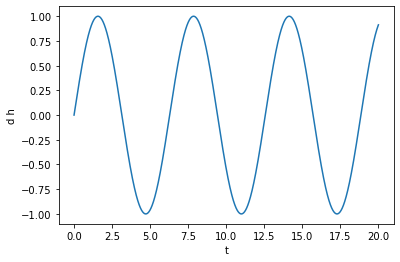

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

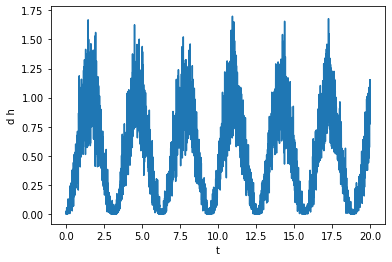

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

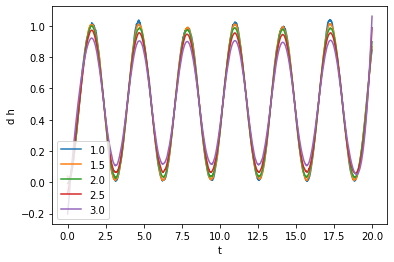

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

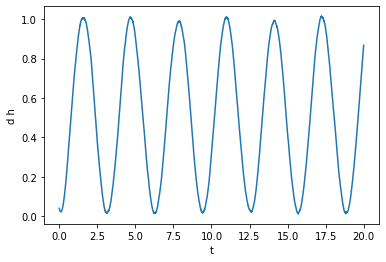

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1780


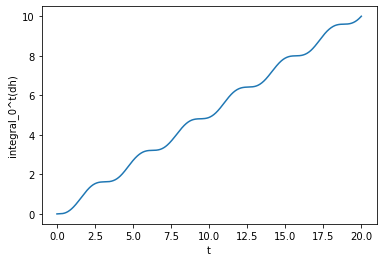

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

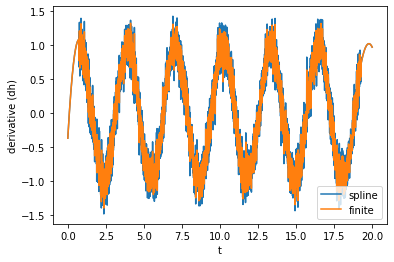

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

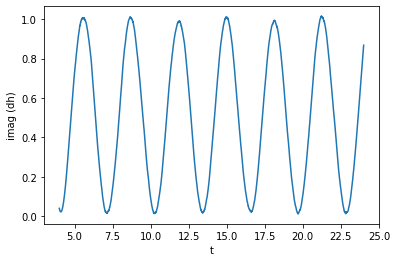

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

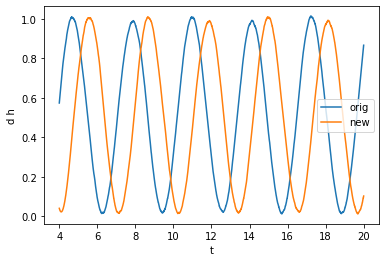

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

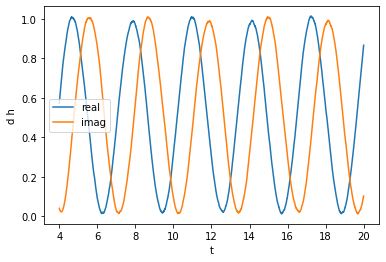

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

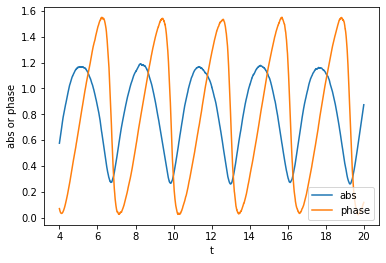

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

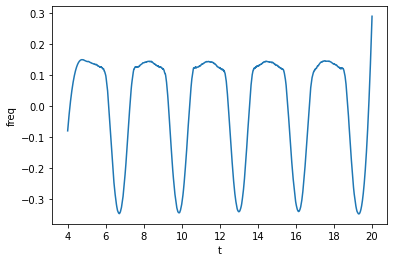

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

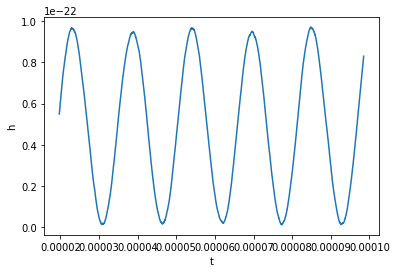

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

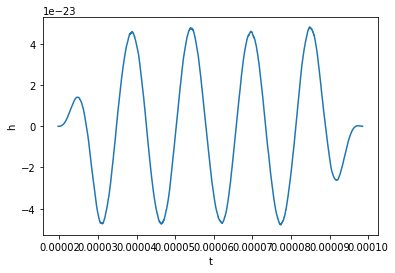

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

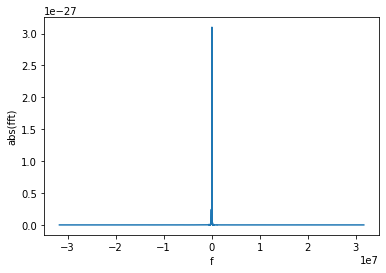

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

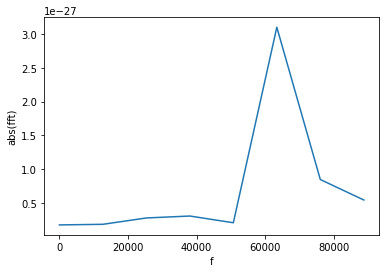

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64220.69


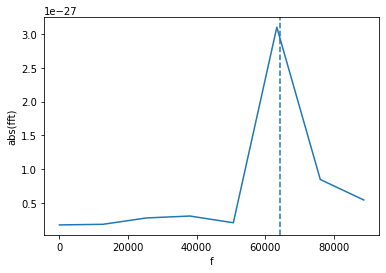

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.098e-27
Maximum with mask 8.486e-28
Length with mask 8
Length after having removed the masked points 7
